# 설치

In [60]:
# !pip install workalendar
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# 데이터 불러오기

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Timestamp
from workalendar.asia import SouthKorea
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# plt.rc('font', family='NanumBarunGothic')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# train_df=pd.read_csv("/content/drive/MyDrive/open/train.csv")
# test_df=pd.read_csv("/content/drive/MyDrive/open/test.csv")
# ss=pd.read_csv("/content/drive/MyDrive/open/sample_submission.csv")
# total_df=pd.read_csv("/content/drive/MyDrive/open/external_open/countrywide_accident.csv")

train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
ss=pd.read_csv("sample_submission.csv")
total_df=pd.read_csv("./external_open/countrywide_accident.csv")

In [62]:
country_df=pd.concat([train_df, total_df])

# 전체 데이터 파생변수

In [63]:
# == ID 패스 ==

# == 사고일시 ==
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

country_df[['연', '월', '일', '시간']] = country_df['사고일시'].str.extract(time_pattern)
country_df[['연', '월', '일', '시간']] = country_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다

# = 공휴일 column 추가 =
def is_holiday(year, month, day):
    cal = SouthKorea()
    return cal.is_holiday(Timestamp(year, month, day))

def classify_day(year, month, day):
    date = Timestamp(year, month, day)
    if date.dayofweek < 5 and not is_holiday(year, month, day):
        return 0
    else:
        return 1

country_df['Holiday'] = country_df.apply(lambda row: classify_day(row['연'], row['월'], row['일']), axis=1)
country_df.drop(columns=['사고일시'], inplace = True) # 정보 추출이 완료된 '사고일시','일','요일','연' 컬럼은 제거합니다

# == 시군구 ==
location_pattern = r'(\S+) (\S+) (\S+)'

country_df[['도시', '구', '동']] = country_df['시군구'].str.extract(location_pattern)
country_df.drop(columns=['시군구'], inplace = True)

# == 도로형태 ==
road_pattern = r'(.+) - (.+)'

country_df[['도로형태1', '도로형태2']] = country_df['도로형태'].str.extract(road_pattern)
country_df = country_df.drop(columns=['도로형태2'])

# == 기상상태
country_df.drop(["기상상태"], axis=1, inplace=True)

In [64]:
# == 연령
g_age = r'(\d{2})세'
p_age = r'(\d{1,2})세'

country_df["가해운전자 연령"] = country_df['가해운전자 연령'].str.extract(g_age)
country_df["피해운전자 연령"] = country_df['피해운전자 연령'].str.extract(p_age)

country_df["가해운전자 연령"]=country_df["가해운전자 연령"].apply(pd.to_numeric)
country_df["피해운전자 연령"]=country_df["피해운전자 연령"].apply(pd.to_numeric)

In [65]:
# == ID 패스 ==

# == 사고일시 ==
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다

# = 공휴일 column 추가 =
def is_holiday(year, month, day):
    cal = SouthKorea()
    return cal.is_holiday(Timestamp(year, month, day))

def classify_day(year, month, day):
    date = Timestamp(year, month, day)
    if date.dayofweek < 5 and not is_holiday(year, month, day):
        return 0
    else:
        return 1

test_df['Holiday'] = test_df.apply(lambda row: classify_day(row['연'], row['월'], row['일']), axis=1)
test_df.drop(columns=['사고일시'], inplace = True) # 정보 추출이 완료된 '사고일시','일','요일','연' 컬럼은 제거합니다

# == 시군구 ==
location_pattern = r'(\S+) (\S+) (\S+)'

test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df.drop(columns=['시군구'], inplace = True)

# == 도로형태 ==
road_pattern = r'(.+) - (.+)'

test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태2'])

# == 기상상태
test_df.drop(["기상상태"], axis=1, inplace=True)

In [66]:
# 차대차, 차대사람의 데이터
not_car = country_df[country_df['사고유형'] != '차량단독'].copy()
not_car.reset_index(inplace=True, drop=True)

# 차량단독의 데이터
car = country_df[country_df['사고유형'] == '차량단독'].copy()
car.reset_index(inplace=True, drop=True)

# 차량단독에서 ('노면상태', '가해운전자 연령', '도시', '구', '동') column에 대한 결측치 drop
car = car.dropna(subset=['노면상태', '가해운전자 연령', '도시', '구', '동'])
car.reset_index(inplace=True, drop=True)

# 차량단독의 경우 피해운전자 차종은 미분류나 결측치임. 따라서 없음으로 대치
car['피해운전자 차종'] = '없음'

# 차량단독이 아닌 경우에 대해서는 결측치 모두 drop
not_car = not_car.dropna()
not_car.reset_index(inplace=True, drop=True)

# 차량단독과 차량단독이 아닌 경우를 합쳐서 전체 데이터 형성
country_df = pd.concat([car, not_car], axis=0)
country_df.reset_index(inplace=True, drop=True)

In [67]:
# train_df(대구 데이터)와 country_df(전체 도시 데이터)의 object형 column 확인

train_df=country_df[country_df["도시"]=="대구광역시"]
country_df=country_df[country_df["도시"]!="대구광역시"]
temp_obj_col = []
con_obj_col = []
for col in train_df.columns:
    if train_df[col].dtype == object:
        temp_obj_col.append(col)
for col in country_df.columns:
    if country_df[col].dtype == object:
        con_obj_col.append(col)

In [68]:
#대구 데이터에 없는 object형 변수 값을 갖고 있는 전체 도시 데이터의 인덱스를 파악
not_using_cols = ['ID', '도시', '구', '동', "도로형태1"]

idxs = []
for col in con_obj_col:
    if col not in not_using_cols:
        temp_values = list(train_df[col].unique())
        total_values = list(country_df[col].unique())

        unique = []

        for tvalue in total_values:
            if tvalue not in temp_values:
                unique.append(tvalue)

        for u in unique:
            idx = country_df[country_df[col]==u].index.to_list()
            idxs = idxs + idx

idxs = list(set(idxs))

In [69]:
country_df = country_df.drop(idxs, axis=0)
country_df.reset_index(inplace=True, drop=True)
country_df=pd.concat([train_df, country_df])

## 사고유형에 따라 데이터 분리

In [132]:
train1=country_df[country_df["사고유형"]=="차량단독"]
train2=country_df[country_df["사고유형"]=="차대차"]
train3=country_df[country_df["사고유형"]=="차대사람"]
test1=test_df[test_df["사고유형"]=="차량단독"]
test2=test_df[test_df["사고유형"]=="차대차"]
test3=test_df[test_df["사고유형"]=="차대사람"]

display(train1.shape)
display(train2.shape)
display(train3.shape)

(26620, 29)

(489871, 29)

(113105, 29)

In [133]:
# 컬렴 별 위험도를 측정 후 구 별로 컬럼별 발생 비율을 반영한 가중치
def danger(df, column):
    col=str(column)
    column_dangerous=df[[col, "ECLO"]].groupby(col).mean()
    column_dangerous.columns=[col+"_dangerous"]
    column_count=df[["도시", "구", col]]
    column_count["cnt"]=1
    column_count=column_count.groupby(["도시", "구", col]).count()
    column_count.reset_index(inplace=True)
    temp=pd.merge(column_count, column_dangerous, how="left", on=[col])
    temp['multiply'] = temp['cnt']*temp[col+'_dangerous']
    temp = temp.groupby(['도시','구']).sum().reset_index().drop([col+"_dangerous"],axis=1)
    temp[col+'_dangerous'] = temp['multiply']/temp['cnt']
    temp.drop([column,'multiply','cnt'],axis=1,inplace=True)
    return temp

In [134]:
#차량 단독
def feat_eng1(df) :
    global test1
    # == 이상치 1% 제거
    sns.boxplot(x="ECLO", data=df)
    plt.show()
    def set_limit(column):
        return np.quantile(column, 0.999)

    df_copy = df.copy()
    df_copy = df_copy[[ '노면상태', '사고유형', '사고유형 - 세부분류', '도로형태', 'ECLO']]
    df_copy.reset_index(inplace=True, drop=True)

    outlier_idxs = []
    for col in df_copy.columns[:-1]:
        temp_df = pd.DataFrame(df_copy.groupby(col)['ECLO'].agg(set_limit)).reset_index()
        for j in range(len(temp_df)):
            s_idxs = df[(df[col] == temp_df.loc[j, col]) & (df['ECLO'] > temp_df.loc[j, 'ECLO'])].index.to_list()
            outlier_idxs = outlier_idxs + s_idxs
    outliers = list(set(outlier_idxs))

    print('outlier 수 : ', len(outliers))

    df = df.drop(outliers, axis=0)
    df.reset_index(inplace=True, drop=True)

    print(len(df))
    sns.boxplot(x="ECLO", data=df)
    plt.show()

    # == 사고유형 -> drop
    df.drop(["사고유형"], axis=1, inplace=True)

    # == 지역별 가해운전자 & 피해운전자 평균 연령 추출
    age_mean = df[['도시','구','동','가해운전자 연령']].groupby(['도시', '구','동']).mean()
    age_mean.columns = ['가해운전자 평균연령']
    df = pd.merge(df, age_mean, how="left", on=["도시", "구", "동"])
    test_eng = pd.merge(test1, age_mean, how="left", on=["도시", "구", "동"]).drop(columns=["사고유형"])
    test_eng[['가해운전자 평균연령']]=test_eng[['가해운전자 평균연령']].fillna(test_eng[['가해운전자 평균연령']].mean())

    # == 지역별 가해운전자 & 피해운전자 평균 성별 추출
    def sex_transform(x):
        if x=='남':
            return 1
        elif x=='여':
            return 0
        else:
            return np.NaN
    df['가해운전자 성별'] = df['가해운전자 성별'].apply(lambda x:sex_transform(x))
    sex_mean = df[['도시','구','동','가해운전자 성별']].groupby(['도시', '구','동']).mean()
    sex_mean.columns = ['가해운전자 평균성별']
    df = pd.merge(df, sex_mean, how="left", on=["도시", "구", "동"])
    test_eng = pd.merge(test_eng, sex_mean, how="left", on=["도시", "구", "동"])
    test_eng[['가해운전자 평균성별']] = test_eng[['가해운전자 평균성별']].fillna(test_eng[['가해운전자 평균성별']].mean())
    
    # == 가해노인운전자 위험도
    def sepa(x):
        if x>=65 :
            return 1
        else :
            return 0
        
    df["가해운전자 연령"]=df["가해운전자 연령"].apply(sepa)
    old_count = df[["도시", "구", "가해운전자 연령"]]
    old_count["cnt"]=1
    old_count = old_count.groupby(["도시", "구"]).sum().reset_index()
    old_count["ratio"]=old_count["가해운전자 연령"]/old_count["cnt"]
    old_eclo=df[df["가해운전자 연령"]==1][["도시", "구", "ECLO"]]
    old_eclo = old_eclo.groupby(["도시", "구"]).mean().reset_index()
    temp=pd.merge(old_count, old_eclo, how="left", on=["도시", "구"])
    temp.fillna(0, inplace=True)
    temp["가해노인운전자 위험도"]=temp["ratio"]*temp["ECLO"]
    temp.drop(["가해운전자 연령", "cnt", "ratio", "ECLO"], axis=1, inplace=True)

    df = pd.merge(df, temp, how="left", on=["도시", "구"])
    test_eng = pd.merge(test_eng, temp, how="left", on=["도시", "구"])

    # 가해운전자 차종 별 위험도
    danger1=danger(df, "가해운전자 차종")

    df = pd.merge(df, danger1, how="left", on=["도시", "구"])
    test_eng = pd.merge(test_eng, danger1, how="left", on=["도시", "구"])

    # == 칼럼 동기화
    test_eng = test_eng.drop(columns=["ID"])
    ytrain = df["ECLO"]
    df = df[test_eng.columns]


    # == 원핫 인코딩
    one_hot_features=['노면상태',"도로형태1"]

    train_oh=pd.get_dummies(df[one_hot_features])
    test_oh=pd.get_dummies(test_eng[one_hot_features])

    for i in train_oh.columns:
        if i not in test_oh.columns:
            test_oh[i]=0
    for i in test_oh.columns:
        if i not in train_oh.columns:
            train_oh[i]=0

    display(len(test_oh.columns),len(train_oh.columns))

    df.drop(one_hot_features,axis=1,inplace=True)
    test_eng.drop(one_hot_features,axis=1,inplace=True)

    df=pd.concat([df,train_oh],axis=1)
    test_eng=pd.concat([test_eng,test_oh],axis=1)

    df=df.drop(columns=["일"])
    # == 레이블 인코딩
    label_features = ["요일", "도시", "구", "동", "도로형태"]

    display(label_features)

    for i in label_features:
        print(i)
        le = LabelEncoder()
        le=le.fit(df[i])
        df[i]=le.transform(df[i])

        for case in np.unique(test_eng[i]):
            if case not in le.classes_:
                print('test case is not in classes')
                le.classes_ = np.append(le.classes_, case)
        test_eng[i]=le.transform(test_eng[i])

    # == 타겟 인코딩

    return df, ytrain ,test_eng

In [135]:
# 차대차
def feat_eng2(df) :
    global test2
    # == 이상치 1% 제거
    sns.boxplot(x="ECLO", data=df)
    plt.show()
    def set_limit(column):
        return np.quantile(column, 0.999)

    df_copy = df.copy()
    df_copy = df_copy[[ '노면상태', '사고유형', '사고유형 - 세부분류', '도로형태', 'ECLO']]
    df_copy.reset_index(inplace=True, drop=True)

    outlier_idxs = []
    for col in df_copy.columns[:-1]:
        temp_df = pd.DataFrame(df_copy.groupby(col)['ECLO'].agg(set_limit)).reset_index()
        for j in range(len(temp_df)):
            s_idxs = df[(df[col] == temp_df.loc[j, col]) & (df['ECLO'] > temp_df.loc[j, 'ECLO'])].index.to_list()
            outlier_idxs = outlier_idxs + s_idxs
    outliers = list(set(outlier_idxs))

    print('outlier 수 : ', len(outliers))

    df = df.drop(outliers, axis=0)
    df.reset_index(inplace=True, drop=True)

    print(len(df))
    sns.boxplot(x="ECLO", data=df)
    plt.show()

    # == 사고유형 -> drop
    df.drop(["사고유형"], axis=1, inplace=True)

    # == 지역별 가해운전자 & 피해운전자 평균 연령 추출
    age_mean = df[['도시','구','동','가해운전자 연령', "피해운전자 연령"]].groupby(['도시', '구','동']).mean()
    age_mean.columns = ['가해운전자 평균연령', "피해운전자 평균연령"]
    df = pd.merge(df, age_mean, how="left", on=["도시", "구", "동"])
    test_eng = pd.merge(test2, age_mean, how="left", on=["도시", "구", "동"]).drop(columns=["사고유형"])
    test_eng[['가해운전자 평균연령','피해운전자 평균연령']]=test_eng[['가해운전자 평균연령','피해운전자 평균연령']].fillna(test_eng[['가해운전자 평균연령','피해운전자 평균연령']].mean())

    # == 지역별 가해운전자 & 피해운전자 평균 성별 추출
    def sex_transform(x):
        if x=='남':
            return 1
        elif x=='여':
            return 0
        else:
            return np.NaN
    df['가해운전자 성별'] = df['가해운전자 성별'].apply(lambda x:sex_transform(x))
    df['피해운전자 성별'] = df['피해운전자 성별'].apply(lambda x:sex_transform(x))
    sex_mean = df[['도시','구','동','가해운전자 성별','피해운전자 성별']].groupby(['도시', '구','동']).mean()
    sex_mean.columns = ['가해운전자 평균성별','피해운전자 평균성별']
    df = pd.merge(df, sex_mean, how="left", on=["도시", "구", "동"])
    test_eng = pd.merge(test_eng, sex_mean, how="left", on=["도시", "구", "동"])
    test_eng[['가해운전자 평균성별','피해운전자 평균성별']]=test_eng[['가해운전자 평균성별','피해운전자 평균성별']].fillna(test_eng[['가해운전자 평균성별','피해운전자 평균성별']].mean())

    # 가해운전자 차종 별 위험도
    danger21=danger(df, "가해운전자 차종")

    df = pd.merge(df, danger21, how="left", on=["도시", "구"])
    test_eng = pd.merge(test_eng, danger21, how="left", on=["도시", "구"])
    # 피해운전자 차종 별 위험도
    danger22=danger(df, "피해운전자 차종")

    df = pd.merge(df, danger22, how="left", on=["도시", "구"])
    test_eng = pd.merge(test_eng, danger22, how="left", on=["도시", "구"])

    # == 칼럼 동기화
    test_eng = test_eng.drop(columns=["ID"])
    ytrain = df["ECLO"]
    df = df[test_eng.columns]


    # == 원핫 인코딩
    one_hot_features=['노면상태', "도로형태1"]

    train_oh=pd.get_dummies(df[one_hot_features])
    test_oh=pd.get_dummies(test_eng[one_hot_features])

    for i in train_oh.columns:
        if i not in test_oh.columns:
            test_oh[i]=0
    for i in test_oh.columns:
        if i not in train_oh.columns:
            train_oh[i]=0

    display(len(test_oh.columns),len(train_oh.columns))

    df.drop(one_hot_features,axis=1,inplace=True)
    test_eng.drop(one_hot_features,axis=1,inplace=True)

    df=pd.concat([df,train_oh],axis=1)
    test_eng=pd.concat([test_eng,test_oh],axis=1)

    df=df.drop(columns=["일"])
    # == 레이블 인코딩
    label_features = ["요일", "도시", "구", "동", "도로형태"]

    display(label_features)

    for i in label_features:
        print(i)
        le = LabelEncoder()
        le=le.fit(df[i])
        df[i]=le.transform(df[i])

        for case in np.unique(test_eng[i]):
            if case not in le.classes_:
                print('test case is not in classes')
                le.classes_ = np.append(le.classes_, case)
        test_eng[i]=le.transform(test_eng[i])

    # == 타겟 인코딩

    return df, ytrain ,test_eng

In [136]:
# 차대 사람
def feat_eng3(df) :
    global test3
    # == 이상치 1% 제거
    sns.boxplot(x="ECLO", data=df)
    plt.show()
    def set_limit(column):
        return np.quantile(column, 0.999)

    df_copy = df.copy()
    df_copy = df_copy[[ '노면상태', '사고유형', '사고유형 - 세부분류', '도로형태', 'ECLO']]
    df_copy.reset_index(inplace=True, drop=True)

    outlier_idxs = []
    for col in df_copy.columns[:-1]:
        temp_df = pd.DataFrame(df_copy.groupby(col)['ECLO'].agg(set_limit)).reset_index()
        for j in range(len(temp_df)):
            s_idxs = df[(df[col] == temp_df.loc[j, col]) & (df['ECLO'] > temp_df.loc[j, 'ECLO'])].index.to_list()
            outlier_idxs = outlier_idxs + s_idxs
    outliers = list(set(outlier_idxs))

    print('outlier 수 : ', len(outliers))

    df = df.drop(outliers, axis=0)
    df.reset_index(inplace=True, drop=True)

    print(len(df))
    sns.boxplot(x="ECLO", data=df)
    plt.show()

    # == 사고유형 -> drop
    df.drop(["사고유형"], axis=1, inplace=True)

    # == 지역별 가해운전자 & 피해운전자 평균 연령 추출
    age_mean = df[['도시','구','동','가해운전자 연령', "피해운전자 연령"]].groupby(['도시', '구','동']).mean()
    age_mean.columns = ['가해운전자 평균연령', "피해운전자 평균연령"]
    df = pd.merge(df, age_mean, how="left", on=["도시", "구", "동"])
    test_eng = pd.merge(test3, age_mean, how="left", on=["도시", "구", "동"]).drop(columns=["사고유형"])
    test_eng[['가해운전자 평균연령','피해운전자 평균연령']]=test_eng[['가해운전자 평균연령','피해운전자 평균연령']].fillna(test_eng[['가해운전자 평균연령','피해운전자 평균연령']].mean())

    # == 지역별 가해운전자 & 피해운전자 평균 성별 추출
    def sex_transform(x):
        if x=='남':
            return 1
        elif x=='여':
            return 0
        else:
            return np.NaN
    df['가해운전자 성별'] = df['가해운전자 성별'].apply(lambda x:sex_transform(x))
    df['피해운전자 성별'] = df['피해운전자 성별'].apply(lambda x:sex_transform(x))
    sex_mean = df[['도시','구','동','가해운전자 성별','피해운전자 성별']].groupby(['도시', '구','동']).mean()
    sex_mean.columns = ['가해운전자 평균성별','피해운전자 평균성별']
    df = pd.merge(df, sex_mean, how="left", on=["도시", "구", "동"])
    test_eng = pd.merge(test_eng, sex_mean, how="left", on=["도시", "구", "동"])
    test_eng[['가해운전자 평균성별','피해운전자 평균성별']]=test_eng[['가해운전자 평균성별','피해운전자 평균성별']].fillna(test_eng[['가해운전자 평균성별','피해운전자 평균성별']].mean())

    # == 피해 & 가해 노인운전자 위험도
    def sepa(x):
        if x>=65 :
            return 1
        else :
            return 0
    # df["가해운전자 연령"]=df["가해운전자 연령"].apply(sepa)
    # old_count1 = df[["도시", "구", "가해운전자 연령"]]
    # old_count1["cnt"]=1
    # old_count1 = old_count1.groupby(["도시", "구"]).sum().reset_index()
    # old_count1["ratio"]=old_count1["가해운전자 연령"]/old_count1["cnt"]
    # old_eclo1=df[df["가해운전자 연령"]==1][["도시", "구", "ECLO"]]
    # old_eclo1 = old_eclo1.groupby(["도시", "구"]).mean().reset_index()
    # temp1=pd.merge(old_count1, old_eclo1, how="left", on=["도시", "구"])
    # temp1.fillna(0, inplace=True)
    # temp1["가해노인운전자 위험도"]=temp1["ratio"]*temp1["ECLO"]
    # temp1.drop(["가해운전자 연령", "cnt", "ratio", "ECLO"], axis=1, inplace=True)

    df["피해운전자 연령"]=df["피해운전자 연령"].apply(sepa)
    old_count2 = df[["도시", "구", "피해운전자 연령"]]
    old_count2["cnt"]=1
    old_count2 = old_count2.groupby(["도시", "구"]).sum().reset_index()
    old_count2["ratio"]=old_count2["피해운전자 연령"]/old_count2["cnt"]
    old_eclo2=df[df["피해운전자 연령"]==1][["도시", "구", "ECLO"]]
    old_eclo2 = old_eclo2.groupby(["도시", "구"]).mean().reset_index()
    temp2=pd.merge(old_count2, old_eclo2, how="left", on=["도시", "구"])
    temp2.fillna(0, inplace=True)
    temp2["피해노인운전자 위험도"]=temp2["ratio"]*temp2["ECLO"]
    temp2.drop(["피해운전자 연령", "cnt", "ratio", "ECLO"], axis=1, inplace=True)

    # df = pd.merge(df, temp1, how="left", on=["도시", "구"])
    # test_eng = pd.merge(test_eng, temp1, how="left", on=["도시", "구"])
    df = pd.merge(df, temp2, how="left", on=["도시", "구"])
    test_eng = pd.merge(test_eng, temp2, how="left", on=["도시", "구"])

    # 가해운전자 차종 별 위험도
    danger31=danger(df, "가해운전자 차종")

    df = pd.merge(df, danger31, how="left", on=["도시", "구"])
    test_eng = pd.merge(test_eng, danger31, how="left", on=["도시", "구"])

    # 피해운전자 차종 별 위험도
    danger32=danger(df, "피해운전자 차종")

    df = pd.merge(df, danger32, how="left", on=["도시", "구"])
    test_eng = pd.merge(test_eng, danger32, how="left", on=["도시", "구"])

    # == 칼럼 동기화
    test_eng = test_eng.drop(columns=["ID"])
    ytrain = df["ECLO"]
    df = df[test_eng.columns]


    # == 원핫 인코딩
    one_hot_features=['노면상태', "도로형태1"]

    train_oh=pd.get_dummies(df[one_hot_features])
    test_oh=pd.get_dummies(test_eng[one_hot_features])

    for i in train_oh.columns:
        if i not in test_oh.columns:
            test_oh[i]=0
    for i in test_oh.columns:
        if i not in train_oh.columns:
            train_oh[i]=0

    display(len(test_oh.columns),len(train_oh.columns))

    df.drop(one_hot_features,axis=1,inplace=True)
    test_eng.drop(one_hot_features,axis=1,inplace=True)

    df=pd.concat([df,train_oh],axis=1)
    test_eng=pd.concat([test_eng,test_oh],axis=1)

    df=df.drop(columns=["일"])
    # == 레이블 인코딩
    label_features = ["요일", "도시", "구", "동", "도로형태"]

    display(label_features)

    for i in label_features:
        print(i)
        le = LabelEncoder()
        le=le.fit(df[i])
        df[i]=le.transform(df[i])

        for case in np.unique(test_eng[i]):
            if case not in le.classes_:
                print('test case is not in classes')
                le.classes_ = np.append(le.classes_, case)
        test_eng[i]=le.transform(test_eng[i])

    # == 타겟 인코딩

    return df, ytrain ,test_eng

In [137]:
train1.columns

Index(['ID', '요일', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', 'Holiday', '도시', '구', '동', '도로형태1'],
      dtype='object')

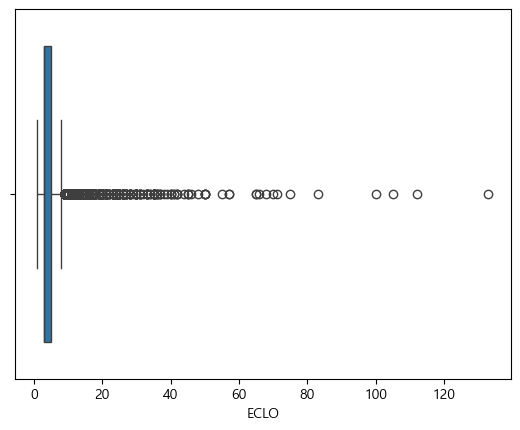

outlier 수 :  42
26575


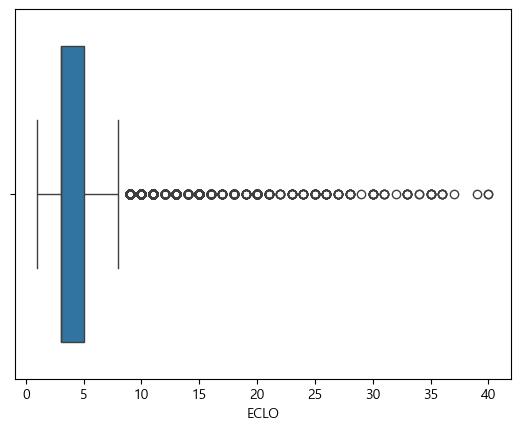

11

11

['요일', '도시', '구', '동', '도로형태']

요일
도시
구
동
test case is not in classes
test case is not in classes
test case is not in classes
test case is not in classes
test case is not in classes
test case is not in classes
test case is not in classes
도로형태


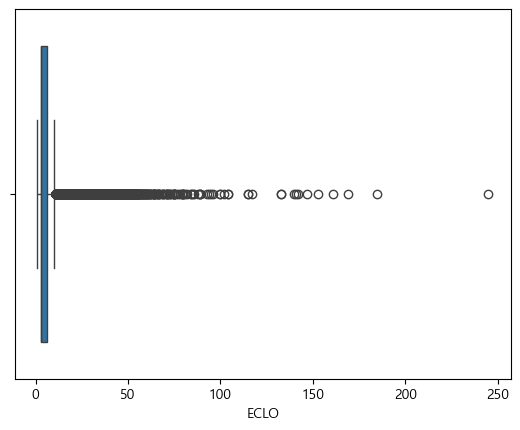

outlier 수 :  634
489180


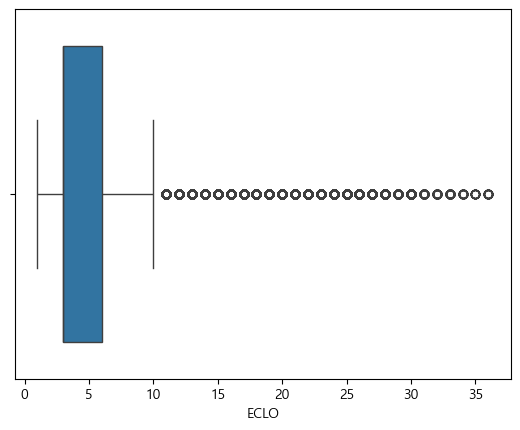

11

11

['요일', '도시', '구', '동', '도로형태']

요일
도시
구
동
도로형태


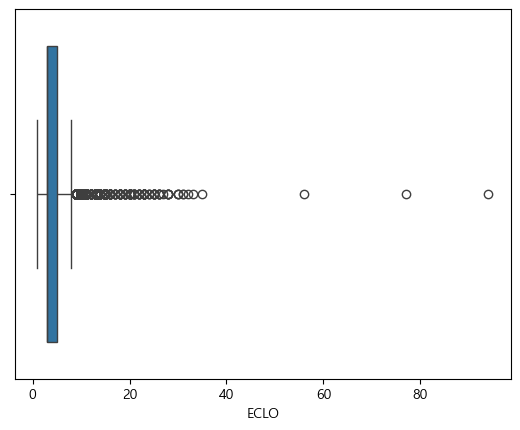

outlier 수 :  125
112976


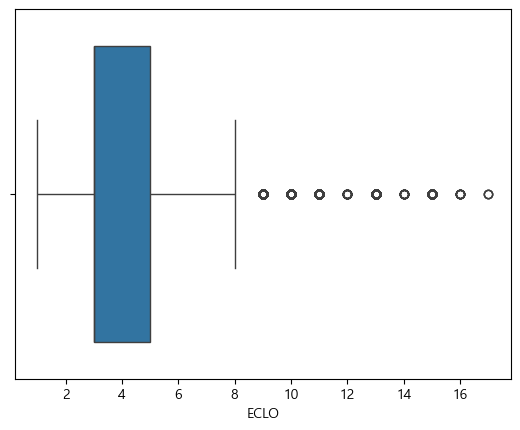

11

11

['요일', '도시', '구', '동', '도로형태']

요일
도시
구
동
test case is not in classes
test case is not in classes
test case is not in classes
test case is not in classes
도로형태


In [138]:
X_train_eng1, y_train1, X_test_eng1=feat_eng1(train1)
X_train_eng2, y_train2, X_test_eng2=feat_eng2(train2)
X_train_eng3, y_train3, X_test_eng3=feat_eng3(train3)

In [139]:
print(X_train_eng1.isnull().sum().sum())
print(X_test_eng1.isnull().sum().sum())
print(y_train1.isnull().sum().sum())
print(X_train_eng2.isnull().sum().sum())
print(X_test_eng2.isnull().sum().sum())
print(y_train2.isnull().sum().sum())
print(X_train_eng3.isnull().sum().sum())
print(X_test_eng3.isnull().sum().sum())
print(y_train3.isnull().sum().sum())

0
0
0
0
0
0
0
0
0


In [140]:
X_train_eng1.columns

Index(['요일', '도로형태', '연', '월', '시간', 'Holiday', '도시', '구', '동', '가해운전자 평균연령',
       '가해운전자 평균성별', '가해노인운전자 위험도', '가해운전자 차종_dangerous', '노면상태_건조', '노면상태_기타',
       '노면상태_서리/결빙', '노면상태_적설', '노면상태_젖음/습기', '노면상태_침수', '도로형태1_교차로',
       '도로형태1_기타', '도로형태1_단일로', '도로형태1_미분류', '도로형태1_주차장'],
      dtype='object')

In [141]:
X_train_eng2.columns

Index(['요일', '도로형태', '연', '월', '시간', 'Holiday', '도시', '구', '동', '가해운전자 평균연령',
       '피해운전자 평균연령', '가해운전자 평균성별', '피해운전자 평균성별', '가해운전자 차종_dangerous',
       '피해운전자 차종_dangerous', '노면상태_건조', '노면상태_기타', '노면상태_서리/결빙', '노면상태_적설',
       '노면상태_젖음/습기', '노면상태_침수', '도로형태1_교차로', '도로형태1_기타', '도로형태1_단일로',
       '도로형태1_미분류', '도로형태1_주차장'],
      dtype='object')

In [142]:
X_train_eng3.columns

Index(['요일', '도로형태', '연', '월', '시간', 'Holiday', '도시', '구', '동', '가해운전자 평균연령',
       '피해운전자 평균연령', '가해운전자 평균성별', '피해운전자 평균성별', '피해노인운전자 위험도',
       '가해운전자 차종_dangerous', '피해운전자 차종_dangerous', '노면상태_건조', '노면상태_기타',
       '노면상태_서리/결빙', '노면상태_적설', '노면상태_젖음/습기', '노면상태_침수', '도로형태1_교차로',
       '도로형태1_기타', '도로형태1_단일로', '도로형태1_미분류', '도로형태1_주차장'],
      dtype='object')

# 하이퍼 파라미터 튜닝

In [143]:
from sklearn.model_selection import train_test_split

# Log transformation of target variable
y_train_log_total1 = np.log1p(y_train1)
X_train1, X_valid1, y_train_log1, y_valid_log1 = train_test_split(X_train_eng1, y_train_log_total1, test_size=0.2, random_state=42, shuffle=True)

y_train_log_total2 = np.log1p(y_train2)
X_train2, X_valid2, y_train_log2, y_valid_log2 = train_test_split(X_train_eng2, y_train_log_total2, test_size=0.2, random_state=42, shuffle=True)

y_train_log_total3 = np.log1p(y_train3)
X_train3, X_valid3, y_train_log3, y_valid_log3 = train_test_split(X_train_eng3, y_train_log_total3, test_size=0.2, random_state=42, shuffle=True)

In [144]:
# !pip install optuna
# !pip install catboost

In [145]:
from lightgbm import LGBMRegressor, early_stopping
import optuna
from sklearn.metrics import mean_squared_log_error as msle

def lgbm_modeling1(X_train, y_train, X_valid, y_valid):
  def objective(trial):
    param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 2, 16),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-2, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 40),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
    }

    model = LGBMRegressor(**param, random_state=42, n_jobs=-1)
    bst_lgbm = model.fit(X_train,y_train, eval_set = [(X_valid,y_valid)], eval_metric='rmse',callbacks=[early_stopping(stopping_rounds=100)])

    preds = bst_lgbm.predict(X_valid)
    if (preds<0).sum()>0:
      print('negative')
      preds = np.where(preds>0,preds,0)
    loss = msle(y_valid,preds)

    return np.sqrt(loss)

  study_lgbm = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=100))
  study_lgbm.optimize(objective,n_trials=30,show_progress_bar=True)

  lgbm_reg = LGBMRegressor(**study_lgbm.best_params, random_state=42, n_jobs=-1)
  lgbm_reg.fit(X_train,y_train,eval_set = [(X_valid,y_valid)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])

  return lgbm_reg,study_lgbm

In [146]:
from catboost import CatBoostRegressor, Pool
import optuna
from sklearn.metrics import mean_squared_log_error as msle

def catboost_modeling1(X_train, y_train, X_valid, y_valid):
    def objective(trial):
        param = {
            'iterations': trial.suggest_int("iterations", 1000, 8000),
            'od_wait': trial.suggest_int('od_wait', 500, 1500),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.2),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 1e-5, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1),
            'random_strength': trial.suggest_uniform('random_strength', 10, 30),
            'depth': trial.suggest_int('depth', 5, 12),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
            'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.00),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
        }

        model = CatBoostRegressor(**param, random_seed=42, thread_count=-1)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose_eval=False)

        preds = model.predict(X_valid)
        if (preds < 0).sum() > 0:
            print('Negative predictions found. Adjusting...')
            preds = np.where(preds > 0, preds, 0)

        loss = msle(y_valid, preds)

        return np.sqrt(loss)

    study_catboost = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=100))
    study_catboost.optimize(objective, n_trials=30, show_progress_bar=True)

    catboost_reg = CatBoostRegressor(**study_catboost.best_params, random_seed=42, thread_count=-1)
    catboost_reg.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose_eval=False)

    return catboost_reg, study_catboost

In [147]:
def lgbm_modeling2(X_train, y_train, X_valid, y_valid):
  def objective(trial):
    param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 16, 512),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth', 8, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-2, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 100),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
    }

    model = LGBMRegressor(**param, random_state=42, n_jobs=-1)
    bst_lgbm = model.fit(X_train,y_train, eval_set = [(X_valid,y_valid)], eval_metric='rmse',callbacks=[early_stopping(stopping_rounds=100)])

    preds = bst_lgbm.predict(X_valid)
    if (preds<0).sum()>0:
      print('negative')
      preds = np.where(preds>0,preds,0)
    loss = msle(y_valid,preds)

    return np.sqrt(loss)

  study_lgbm = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=100))
  study_lgbm.optimize(objective,n_trials=30,show_progress_bar=True)

  lgbm_reg = LGBMRegressor(**study_lgbm.best_params, random_state=42, n_jobs=-1)
  lgbm_reg.fit(X_train,y_train,eval_set = [(X_valid,y_valid)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])

  return lgbm_reg,study_lgbm

In [148]:
from catboost import CatBoostRegressor, Pool
import optuna
from sklearn.metrics import mean_squared_log_error as msle

def catboost_modeling2(X_train, y_train, X_valid, y_valid):
    def objective(trial):
        param = {
            'iterations': trial.suggest_int("iterations", 1000, 15000),
            'od_wait': trial.suggest_int('od_wait', 500, 2000),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.5),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 1e-5, 50),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1),
            'random_strength': trial.suggest_uniform('random_strength', 10, 50),
            'depth': trial.suggest_int('depth', 5, 15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
            'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
        }

        model = CatBoostRegressor(**param, random_seed=42, thread_count=-1)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose_eval=False)

        preds = model.predict(X_valid)
        if (preds < 0).sum() > 0:
            print('Negative predictions found. Adjusting...')
            preds = np.where(preds > 0, preds, 0)

        loss = msle(y_valid, preds)

        return np.sqrt(loss)

    study_catboost = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=100))
    study_catboost.optimize(objective, n_trials=30, show_progress_bar=True)

    catboost_reg = CatBoostRegressor(**study_catboost.best_params, random_seed=42, thread_count=-1)
    catboost_reg.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose_eval=False)

    return catboost_reg, study_catboost

In [149]:
def lgbm_modeling3(X_train, y_train, X_valid, y_valid):
  def objective(trial):
    param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-2, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 25, 75),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
    }

    model = LGBMRegressor(**param, random_state=42, n_jobs=-1)
    bst_lgbm = model.fit(X_train,y_train, eval_set = [(X_valid,y_valid)], eval_metric='rmse',callbacks=[early_stopping(stopping_rounds=100)])

    preds = bst_lgbm.predict(X_valid)
    if (preds<0).sum()>0:
      print('negative')
      preds = np.where(preds>0,preds,0)
    loss = msle(y_valid,preds)

    return np.sqrt(loss)

  study_lgbm = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=100))
  study_lgbm.optimize(objective,n_trials=30,show_progress_bar=True)

  lgbm_reg = LGBMRegressor(**study_lgbm.best_params, random_state=42, n_jobs=-1)
  lgbm_reg.fit(X_train,y_train,eval_set = [(X_valid,y_valid)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])

  return lgbm_reg,study_lgbm

In [150]:
from catboost import CatBoostRegressor, Pool
import optuna
from sklearn.metrics import mean_squared_log_error as msle

def catboost_modeling3(X_train, y_train, X_valid, y_valid):
    def objective(trial):
        param = {
            'iterations': trial.suggest_int("iterations", 1000, 10000),
            'od_wait': trial.suggest_int('od_wait', 500, 2000),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 1e-5, 20),
            'subsample': trial.suggest_uniform('subsample', 0.7, 1),
            'random_strength': trial.suggest_uniform('random_strength', 10, 30),
            'depth': trial.suggest_int('depth', 5, 12),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
            'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        }

        model = CatBoostRegressor(**param, random_seed=42, thread_count=-1)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose_eval=False)

        preds = model.predict(X_valid)
        if (preds < 0).sum() > 0:
            print('Negative predictions found. Adjusting...')
            preds = np.where(preds > 0, preds, 0)

        loss = msle(y_valid, preds)

        return np.sqrt(loss)

    study_catboost = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=100))
    study_catboost.optimize(objective, n_trials=30, show_progress_bar=True)

    catboost_reg = CatBoostRegressor(**study_catboost.best_params, random_seed=42, thread_count=-1)
    catboost_reg.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose_eval=False)

    return catboost_reg, study_catboost

In [151]:
lgbm1, study_lgbm1 = lgbm_modeling1(X_train1, y_train_log1, X_valid1, y_valid_log1)

print(study_lgbm1.best_params)
print(study_lgbm1.best_value)
#Best value: 0.199654

[I 2024-01-05 21:36:15,947] A new study created in memory with name: no-name-c8bb364a-414b-407c-8949-b39ceea8a024


  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[699]	valid_0's rmse: 0.499339
[I 2024-01-05 21:36:16,311] Trial 0 finished with value: 0.19990648901672856 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.7835108155281388, 'reg_alpha': 0.4245175907491331, 'reg_lambda': 8.447761323199037, 'max_depth': 3, 'learning_rate': 0.01323028259781289, 'n_estimators': 704, 'min_child_samples': 37, 'subsample': 0.6546826358739811}. Best is trial 0 with value: 0.19990648901672856.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[812]	valid_0's rmse: 0.498958
[I 2024-01-05 21:36:16,722] Trial 1 finished with value: 0.1996935366370804 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.9673965862936792, 'reg_alpha': 0.20920212211718958, 'reg_lambda': 1.8532821955007506, 'max_depth': 3, 'learning_rate': 0.016584313263890035, 'n_estimators': 981, 'min_child_samples': 37, 'subsample

In [152]:
catboost1, study_catboost1 = catboost_modeling1(X_train1, y_train_log1, X_valid1, y_valid_log1)

print(study_catboost1.best_params)
print(study_catboost1.best_value)
#Best value: 0.199642

[I 2024-01-05 21:36:32,066] A new study created in memory with name: no-name-fd17586d-448f-4b24-8dba-8eae563a43c9


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-01-05 21:36:35,160] Trial 0 finished with value: 0.2003957319986005 and parameters: {'iterations': 4804, 'od_wait': 778, 'learning_rate': 0.09065834224233528, 'reg_lambda': 8.447762875437714, 'subsample': 0.5023594280954863, 'random_strength': 12.431382415662284, 'depth': 10, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 2, 'bagging_temperature': 0.531226814107122, 'colsample_bylevel': 0.9347931725873584}. Best is trial 0 with value: 0.2003957319986005.
[I 2024-01-05 21:36:38,674] Trial 1 finished with value: 0.20001729522333006 and parameters: {'iterations': 2464, 'od_wait': 685, 'learning_rate': 0.030591609188208475, 'reg_lambda': 2.1969827292749957, 'subsample': 0.9893118923536848, 'random_strength': 26.233662981786466, 'depth': 6, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.19729339719432015, 'colsample_bylevel': 0.9640178917734248}. Best is trial 1 with value: 0.20001729522333006.
[I 2024-01-05 21:36:44,392] Trial 2 finished wi

In [153]:
lgbm2,study_lgbm2 = lgbm_modeling2(X_train2, y_train_log2, X_valid2, y_valid_log2)

print(study_lgbm2.best_params)
print(study_lgbm2.best_value)
#Best value: 0.165257

[I 2024-01-05 21:40:05,827] A new study created in memory with name: no-name-63395362-2679-4ec3-a9e4-e50bf58e70d8


  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1026]	valid_0's rmse: 0.449355
[I 2024-01-05 21:40:19,145] Trial 0 finished with value: 0.1652931910882946 and parameters: {'num_leaves': 286, 'colsample_bytree': 0.7835108155281388, 'reg_alpha': 0.4245175907491331, 'reg_lambda': 8.447761323199037, 'max_depth': 8, 'learning_rate': 0.01323028259781289, 'n_estimators': 2342, 'min_child_samples': 92, 'subsample': 0.8273413179369906}. Best is trial 0 with value: 0.1652931910882946.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[803]	valid_0's rmse: 0.449402
[I 2024-01-05 21:40:29,793] Trial 1 finished with value: 0.16530893731772456 and parameters: {'num_leaves': 301, 'colsample_bytree': 0.9673965862936792, 'reg_alpha': 0.20920212211718958, 'reg_lambda': 1.8532821955007506, 'max_depth': 8, 'learning_rate': 0.016584313263890035, 'n_estimators': 2958, 'min_child_samples': 91, 'subsample': 0.8343

In [154]:
catboost2,study_catboost2 = catboost_modeling2(X_train2, y_train_log2, X_valid2, y_valid_log2)

print(study_catboost2.best_params)
print(study_catboost2.best_value)
#Best value: 0.165264

[I 2024-01-05 21:43:36,280] A new study created in memory with name: no-name-c3a64e0f-7d95-42a2-9d4f-96314cd234a7


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-01-05 21:43:54,152] Trial 0 finished with value: 0.16572154424950306 and parameters: {'iterations': 8608, 'od_wait': 917, 'learning_rate': 0.21801361946707523, 'reg_lambda': 42.23880816823386, 'subsample': 0.5023594280954863, 'random_strength': 14.862764831324569, 'depth': 12, 'min_data_in_leaf': 25, 'leaf_estimation_iterations': 3, 'bagging_temperature': 1.996978171423994, 'colsample_bylevel': 0.9347931725873584}. Best is trial 0 with value: 0.16572154424950306.
[I 2024-01-05 21:44:25,797] Trial 1 finished with value: 0.16528877853722226 and parameters: {'iterations': 3929, 'od_wait': 778, 'learning_rate': 0.06310467632748501, 'reg_lambda': 10.984882434274681, 'subsample': 0.9893118923536848, 'random_strength': 42.46732596357293, 'depth': 6, 'min_data_in_leaf': 25, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.5331098841434914, 'colsample_bylevel': 0.9640178917734248}. Best is trial 1 with value: 0.16528877853722226.
[I 2024-01-05 21:45:04,951] Trial 2 finished wit

In [155]:
lgbm3,study_lgbm3 = lgbm_modeling3(X_train3, y_train_log3, X_valid3, y_valid_log3)

print(study_lgbm3.best_params)
print(study_lgbm3.best_value)
#Best value: 0.127486

[I 2024-01-05 22:01:36,590] A new study created in memory with name: no-name-f7217f35-05e2-4a25-9107-fa6bc24bd396


  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[652]	valid_0's rmse: 0.315499
[I 2024-01-05 22:01:38,434] Trial 0 finished with value: 0.12754219826479057 and parameters: {'num_leaves': 140, 'colsample_bytree': 0.7835108155281388, 'reg_alpha': 0.4245175907491331, 'reg_lambda': 8.447761323199037, 'max_depth': 6, 'learning_rate': 0.01323028259781289, 'n_estimators': 1506, 'min_child_samples': 67, 'subsample': 0.8273413179369906}. Best is trial 0 with value: 0.12754219826479057.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[515]	valid_0's rmse: 0.315502
[I 2024-01-05 22:01:39,944] Trial 1 finished with value: 0.12753675648911078 and parameters: {'num_leaves': 148, 'colsample_bytree': 0.9673965862936792, 'reg_alpha': 0.20920212211718958, 'reg_lambda': 1.8532821955007506, 'max_depth': 6, 'learning_rate': 0.016584313263890035, 'n_estimators': 1968, 'min_child_samples': 66, 'subsample': 0.834

In [156]:
catboost3,study_catboost3 = catboost_modeling3(X_train3, y_train_log3, X_valid3, y_valid_log3)

print(study_catboost3.best_params)
print(study_catboost3.best_value)
#0.12746

[I 2024-01-05 22:02:17,636] A new study created in memory with name: no-name-a567c888-a581-4549-bc28-12a6753210f8


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-01-05 22:02:29,369] Trial 0 finished with value: 0.12768310211327003 and parameters: {'iterations': 5891, 'od_wait': 917, 'learning_rate': 0.04820658316742198, 'reg_lambda': 16.89552419863675, 'subsample': 0.7014156568572917, 'random_strength': 12.431382415662284, 'depth': 10, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 2, 'bagging_temperature': 1.996978171423994, 'colsample_bylevel': 0.945660977156132}. Best is trial 0 with value: 0.12768310211327003.
[I 2024-01-05 22:02:45,845] Trial 1 finished with value: 0.12747627021881913 and parameters: {'iterations': 2883, 'od_wait': 778, 'learning_rate': 0.01975392014178296, 'reg_lambda': 4.3939576555249165, 'subsample': 0.9935871354122109, 'random_strength': 26.233662981786466, 'depth': 6, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.5331098841434914, 'colsample_bylevel': 0.9700149098111873}. Best is trial 1 with value: 0.12747627021881913.
[I 2024-01-05 22:03:12,596] Trial 2 finished wit

In [ ]:
# lgbm1=LGBMRegressor(random_state=42, n_jobs=-1, **{'num_leaves': 6, 'colsample_bytree': 0.9051637121262273, 'reg_alpha': 0.12566194860571056, 'reg_lambda': 3.2258720581218876, 'max_depth': 3, 'learning_rate': 0.032887812509240916, 'n_estimators': 748, 'min_child_samples': 37, 'subsample': 0.7136285372023218})
# catboost1=CatBoostRegressor(random_seed=42, thread_count=-1, **{'iterations': 6111, 'od_wait': 609, 'learning_rate': 0.04119744178592561, 'reg_lambda': 5.488592836608496, 'subsample': 0.9203846250162546, 'random_strength': 14.883401811234684, 'depth': 5, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.01789129283627206, 'colsample_bylevel': 0.5972283837388589})
# lgbm2=LGBMRegressor(random_state=42, n_jobs=-1, **{'num_leaves': 198, 'colsample_bytree': 0.7423420418793059, 'reg_alpha': 0.1447940808984538, 'reg_lambda': 8.5047864670778, 'max_depth': 8, 'learning_rate': 0.013177148224374527, 'n_estimators': 1061, 'min_child_samples': 81, 'subsample': 0.9892347795263194})
# catboost2=CatBoostRegressor(random_seed=42, thread_count=-1, **{'iterations': 13411, 'od_wait': 1144, 'learning_rate': 0.021727882868213363, 'reg_lambda': 21.015616790374914, 'subsample': 0.878372685297051, 'random_strength': 36.58060974949341, 'depth': 7, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.05180927511974106, 'colsample_bylevel': 0.579406682782964})
# lgbm3=LGBMRegressor(random_state=42, n_jobs=-1, **{'num_leaves': 5, 'colsample_bytree': 0.8672050513192953, 'reg_alpha': 0.7660892889583089, 'reg_lambda': 3.927766971166829, 'max_depth': 8, 'learning_rate': 0.07010556573758032, 'n_estimators': 1671, 'min_child_samples': 49, 'subsample': 0.9631025349553624})
# catboost3=CatBoostRegressor(random_seed=42, thread_count=-1, **{'iterations': 6500, 'od_wait': 1641, 'learning_rate': 0.039883471636645535, 'reg_lambda': 8.723928583044282, 'subsample': 0.8317293182421713, 'random_strength': 22.481544108255296, 'depth': 5, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.022614197973049137, 'colsample_bylevel': 0.7882803255907027})

# lgbm1.fit(X_train1,y_train_log1,eval_set = [(X_valid1,y_valid_log1)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])
# catboost1.fit(X_train1, y_train_log1, eval_set=(X_valid1, y_valid_log1), early_stopping_rounds=100, verbose_eval=False)
# lgbm2.fit(X_train2,y_train_log2,eval_set = [(X_valid2,y_valid_log2)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])
# catboost2.fit(X_train2, y_train_log2, eval_set=(X_valid2, y_valid_log2), early_stopping_rounds=100, verbose_eval=False)
# lgbm3.fit(X_train3,y_train_log3,eval_set = [(X_valid3,y_valid_log3)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])
# catboost3.fit(X_train3, y_train_log3, eval_set=(X_valid3, y_valid_log3), early_stopping_rounds=100, verbose_eval=False)

# 피처 중요도

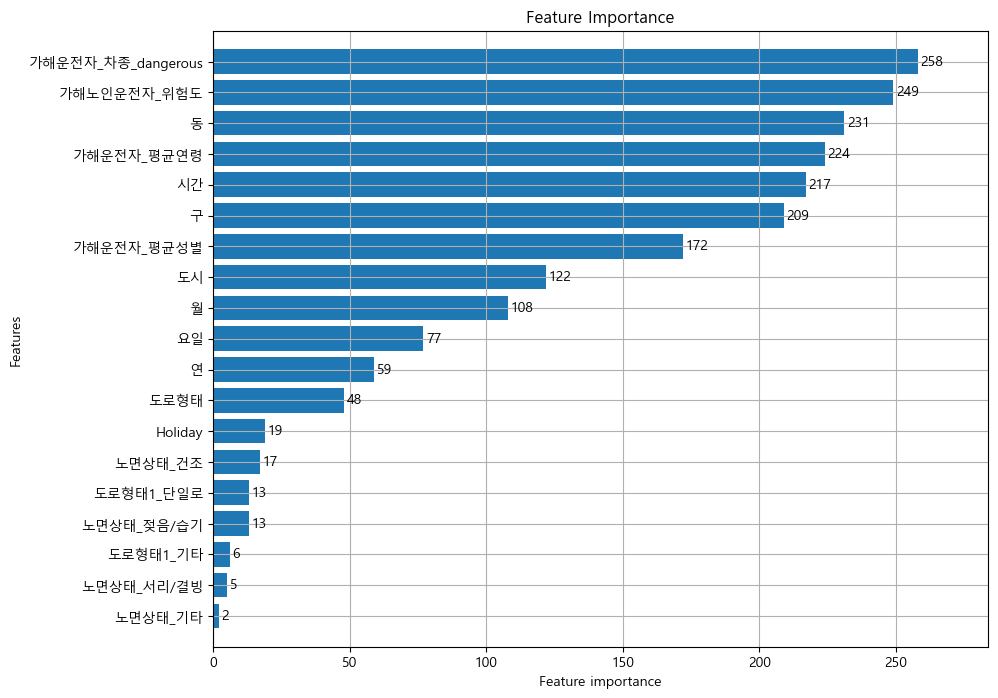

In [157]:
import lightgbm as lgb

lgb.plot_importance(lgbm1, height=0.8, figsize=(10, 8), title="Feature Importance")
plt.show()

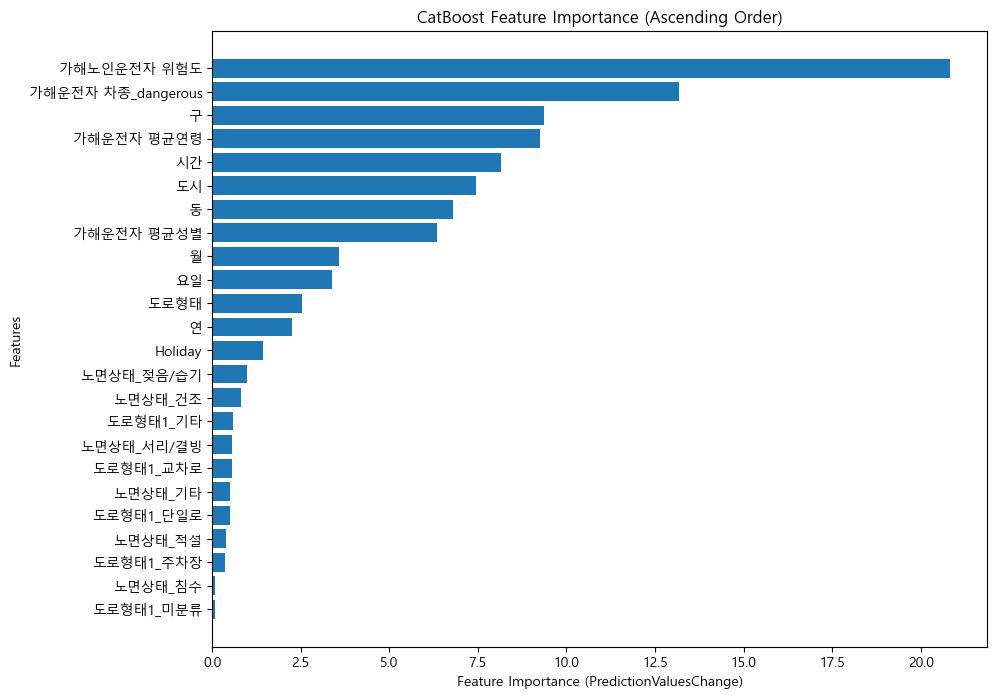

In [158]:
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import pandas as pd

# Assuming catboost1 is your trained CatBoost model
# feature_names is a list containing the names of your features
feature_names_list = list(X_train1.columns)
catboost_pool = Pool(data=X_train1, label=y_train_log1, feature_names=feature_names_list)

feature_importance = catboost1.get_feature_importance(
    data=catboost_pool,
    type='PredictionValuesChange'
)

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names_list, 'Importance': feature_importance})

# Sort the DataFrame by importance values in ascending order
feature_importance_df = feature_importance_df.sort_values(by='Importance')

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance (PredictionValuesChange)')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance (Ascending Order)')
plt.show()

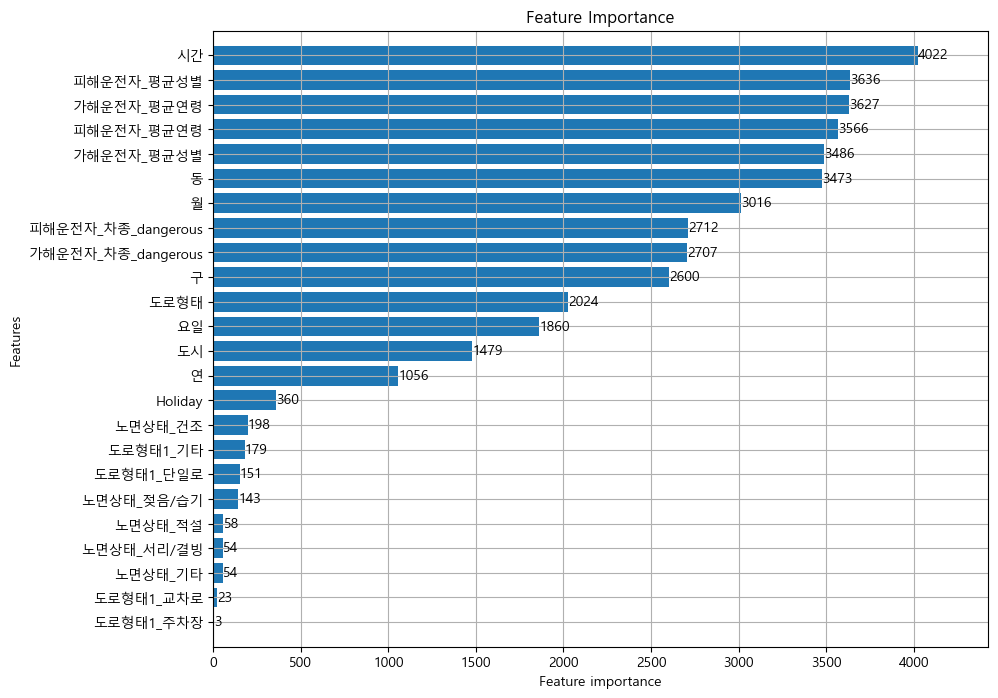

In [159]:
import lightgbm as lgb

lgb.plot_importance(lgbm2, height=0.8, figsize=(10, 8), title="Feature Importance")
plt.show()

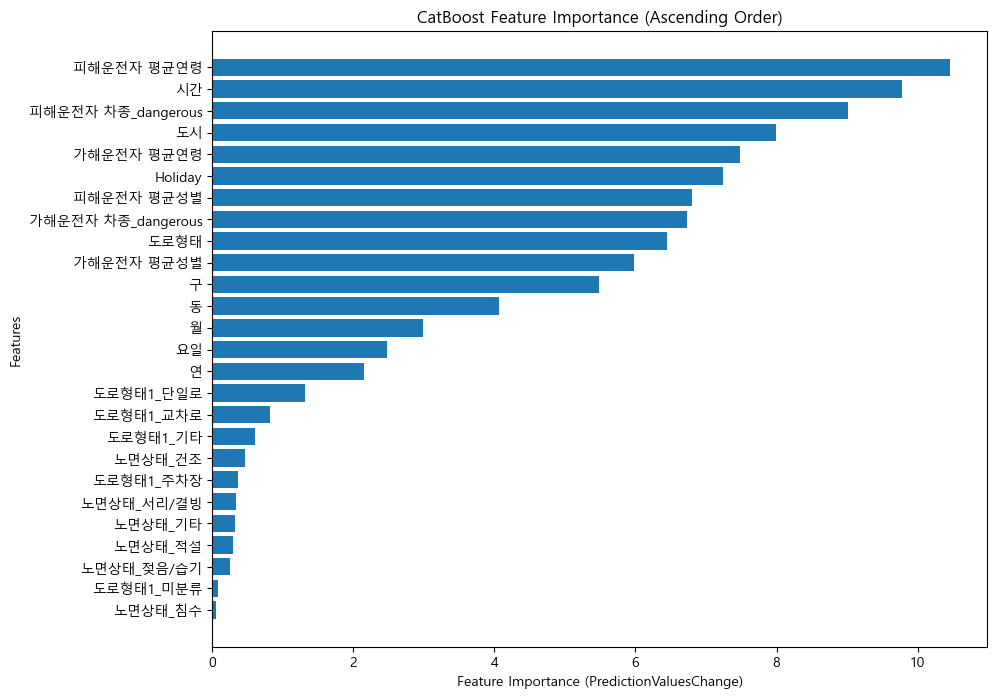

In [169]:
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import pandas as pd

# Assuming catboost2 is your trained CatBoost model
# feature_names is a list containing the names of your features
feature_names_list = list(X_train2.columns)
catboost_pool = Pool(data=X_train2, label=y_train_log2, feature_names=feature_names_list)

feature_importance = catboost2.get_feature_importance(
    data=catboost_pool,
    type='PredictionValuesChange'
)

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names_list, 'Importance': feature_importance})

# Sort the DataFrame by importance values in ascending order
feature_importance_df = feature_importance_df.sort_values(by='Importance')

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance (PredictionValuesChange)')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance (Ascending Order)')
plt.show()

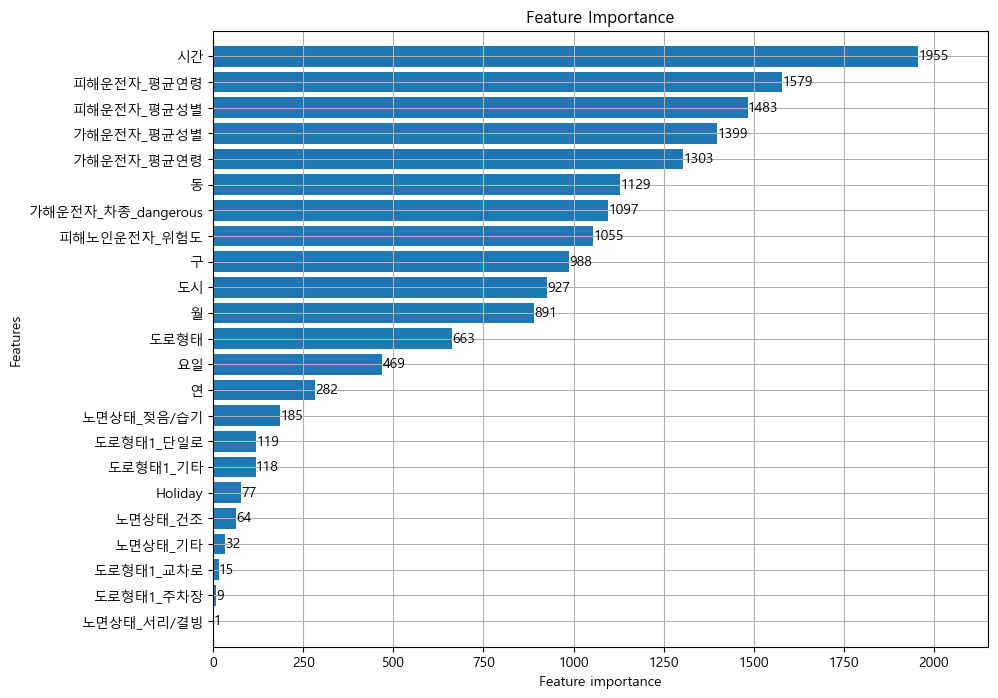

In [173]:
import lightgbm as lgb

lgb.plot_importance(lgbm3, height=0.8, figsize=(10, 8), title="Feature Importance")
plt.show()

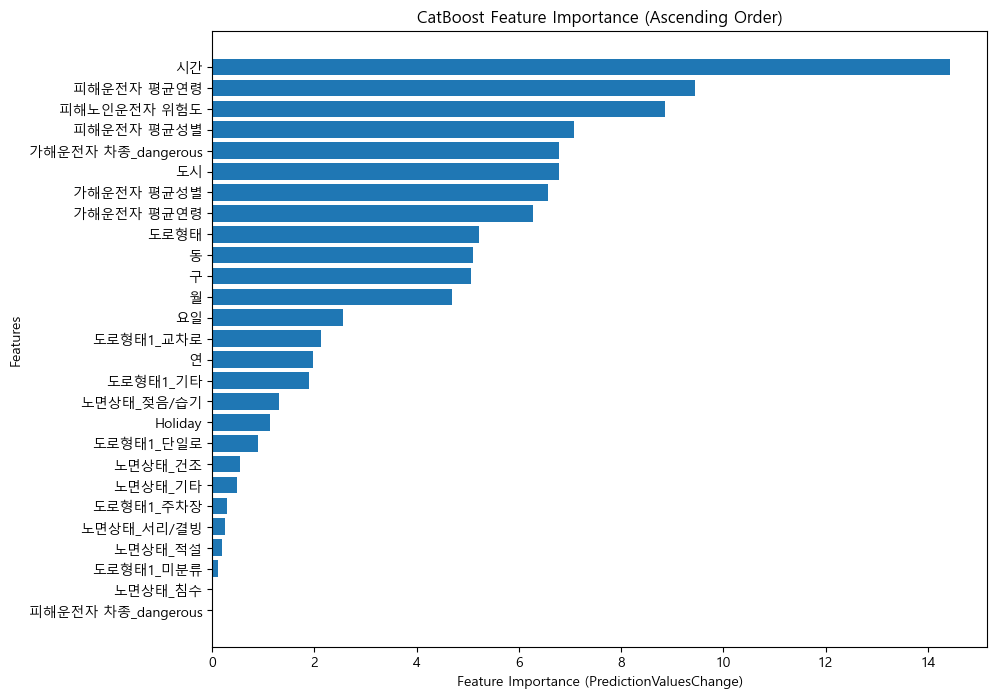

In [172]:
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import pandas as pd

# Assuming catboost3 is your trained CatBoost model
# feature_names is a list containing the names of your features
feature_names_list = list(X_train3.columns)
catboost_pool = Pool(data=X_train3, label=y_train_log3, feature_names=feature_names_list)

feature_importance = catboost3.get_feature_importance(
    data=catboost_pool,
    type='PredictionValuesChange'
)

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names_list, 'Importance': feature_importance})

# Sort the DataFrame by importance values in ascending order
feature_importance_df = feature_importance_df.sort_values(by='Importance')

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance (PredictionValuesChange)')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance (Ascending Order)')
plt.show()

# 제출

In [174]:
X_test_eng1=X_test_eng1.drop(columns=["일"])
X_test_eng2=X_test_eng2.drop(columns=["일"])
X_test_eng3=X_test_eng3.drop(columns=["일"])

KeyError: "['일'] not found in axis"

In [209]:
lgbm_prediction1 = np.expm1(lgbm1.predict(X_test_eng1))
lgbm_prediction2 = np.expm1(lgbm2.predict(X_test_eng2))
lgbm_prediction3 = np.expm1(lgbm3.predict(X_test_eng3))

catboost_prediction1 = np.expm1(catboost1.predict(X_test_eng1))
catboost_prediction2 = np.expm1(catboost2.predict(X_test_eng2))
catboost_prediction3 = np.expm1(catboost3.predict(X_test_eng3))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [210]:
test1["predict"]=lgbm_prediction1*0.2+catboost_prediction1*0.8
test2["predict"]=lgbm_prediction2*0.2+catboost_prediction2*0.8
test3["predict"]=lgbm_prediction3*0.2+catboost_prediction3*0.8

In [211]:
test_f1=pd.merge(test_df, test1[["ID","predict"]], how="left", on="ID" )
test_f1["predict"]=test_f1["predict"].fillna(0)
test_f2=pd.merge(test_f1, test2[["ID","predict"]], how="left", on="ID" )
test_f2["predict_y"]=test_f2["predict_y"].fillna(0)
test_f3=pd.merge(test_f2, test3[["ID","predict"]], how="left", on="ID" )
test_f3["predict"]=test_f3["predict"].fillna(0)
test_f3["predict"]= test_f3["predict_x"]+test_f3["predict_y"]+test_f3["predict"]

In [212]:
ss['ECLO'] = test_f3["predict"]
ss.head()

,ID,ECLO
0,ACCIDENT_39609,3.703970
1,ACCIDENT_39610,3.754431
2,ACCIDENT_39611,5.014371
3,ACCIDENT_39612,4.393168
4,ACCIDENT_39613,4.664876


In [213]:
ss.to_csv(f'제출용-01-05.csv', index=False)